### RUNNING THIS CODE WILL MOST LIKELY REQUIRE PAID COMPUTE.

In [ ]:
# Run this cell first, and restart the environment. Then run the second cell onwards.
!pip install --upgrade --force-reinstall \
    numpy==1.26.4 pandas==2.2.2 \
    transformers sentence-transformers \
    textattack datasets nltk matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 105.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 54.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ..

In [ ]:
# === Imports and Setup ===
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import os
import torch
import nltk
import re
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from textattack.augmentation.recipes import WordNetAugmenter, CharSwapAugmenter, CLAREAugmenter
from nltk.corpus import wordnet
import torch.nn.functional as F
import numpy as np

In [ ]:
# configure environment
HF_TOKEN = ""
os.environ["HF_TOKEN"] = HF_TOKEN

# # download wordnet resources
# nltk.download('omw-1.4')
# nltk.download('wordnet')

# ! unzip /usr/share/nltk_data/corpora/omw-1.4.zip -d /usr/share/nltk_data/corpora > /dev/null
# ! mv /usr/share/nltk_data/corpora/omw-1.4 /usr/share/nltk_data/corpora/omw
# ! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

model_id = "ContactDoctor/Bio-Medical-Llama-3-8B" # set the model id
device = 0  # CUDA 0 (to force GPU usage)

qa_pipeline = pipeline(
    "text-generation", # make sure its text generation
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map=device
)

# initialise semantic model
# semantic_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/53.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16).to(device)
model.gradient_checkpointing_enable()
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# function to extract answer letter in case the model is giving other words apart from the option letter (used for accuracy calculations)
def extract_answer_letter(text):
    match = re.search(r"\b([A-D])\b", text.upper())
    return match.group(1) if match else ""

def extract_answer_part(decoded_texts, marker_text = "Answer:"):
    extracted_answers = []
    for i, text in enumerate(decoded_texts):
        # Split the string into two parts at the first occurrence of the marker
        parts = text.split(marker_text, 1)

        if len(parts) == 2:
            # If the split worked (marker was found), take the second part
            # .strip() removes leading/trailing whitespace (like newlines)
            answer_part = parts[1].strip()
            extracted_answers.append(answer_part)
        else:
            # Marker was not found in this text
            print(f"Warning: Marker '{marker_text}' not found in sequence {i}. Original text (first 100 chars): '{text[:100]}...'")
            extracted_answers.append("") # Append an empty string, or handle as needed
            # Alternatively, you could append the original text:
            # extracted_answers.append(text)

    return extracted_answers

# used for robustness evaluation with accuracy
def build_prompt(question_text, opts):
    return (
        "You are a knowledgeable medical expert. Read the following question carefully and choose the most appropriate answer from the options provided. "
        "Respond with only the letter corresponding to your answer choice (A, B, C or D).\n\n"
        f"Question:\n{question_text}\n\n"
        f"Options:\n"
        f"A. {opts[0]}\n"
        f"B. {opts[1]}\n"
        f"C. {opts[2]}\n"
        f"D. {opts[3]}\n\n"
        "Answer:"
    )

# used for semantic entropy
def build_explained_prompt(question_text, opts):
    return (
        "You are a knowledgeable medical expert. Carefully analyse the following question and answer with short explanation.\n\n"
        f"Question:\n{question_text}\n\n"
        "Answer:"
    )

In [ ]:
import torch
import torch.nn.functional as F
import math

def calculate_semantic_entropy(logits, input_ids, max_entropy=10.0):
    """
    Calculate normalized semantic entropy from model logits.

    Args:
        logits (torch.Tensor): Logits tensor from model.generate with output_scores=True,
                              shape (steps, beam_size, vocab_size)
        input_ids (torch.Tensor): Token IDs of the generated sequences, shape (beam_size, sequence_length).
        max_entropy (float): Maximum possible entropy for normalization (default: 10.0).

    Returns:
        float: Normalized semantic entropy in the range [0, 1].
    """
    beam_size = input_ids.shape[0]

    # Step 1: Compute sequence log-probabilities for each beam
    sequence_log_probs = []

    for i in range(beam_size):
        seq_log_prob = 0.0

        # Process each token position
        for t in range(min(len(logits), input_ids.shape[1])):
            # Get the token ID for this position in this beam
            token_idx = input_ids[i, t].item()

            # Get logits for this step and convert to probabilities
            step_logits = logits[t]  # Shape: (beam_size, vocab_size)
            probs = F.softmax(step_logits, dim=-1)  # Shape: (beam_size, vocab_size)

            # Get probability for the selected token
            if i < probs.shape[0] and token_idx < probs.shape[1]:
                token_prob = probs[i, token_idx].item()

                # Add log probability
                if token_prob > 0:  # Avoid log(0)
                    seq_log_prob += math.log(token_prob)
                else:
                    seq_log_prob += math.log(1e-10)  # Small epsilon value

        sequence_log_probs.append(seq_log_prob)

    # Step 2: Convert log probabilities to probabilities
    sequence_probs = [math.exp(log_p) for log_p in sequence_log_probs]

    # Step 3: Normalize to create a proper probability distribution
    total = sum(sequence_probs)
    if total > 0:
        normalized_probs = [p / total for p in sequence_probs]
    else:
        normalized_probs = [1.0 / beam_size] * beam_size  # Uniform distribution as fallback

    # Step 4: Calculate entropy: -∑(p_i * log(p_i))
    entropy = 0.0
    for p in normalized_probs:
        if p > 0:  # Avoid log(0)
            entropy -= p * math.log(p)

    # Step 5: Normalize entropy to [0, 1] range
    normalized_entropy = min(entropy / max_entropy, 1.0)

    return normalized_entropy

In [ ]:
# load the dataset (100 random question and answer sets from medMCQA)
dataset = load_dataset("medmcqa", split="validation")
dataset = dataset.filter(lambda example: example["choice_type"] == "single")
dataset = dataset.shuffle(seed=42).select(range(8))

questions = [ex["question"] for ex in dataset] # extract question text from dataset
options_list = [[ex["opa"], ex["opb"], ex["opc"], ex["opd"]] for ex in dataset] # extract the 4 options
correct_indices = [int(ex["cop"]) for ex in dataset] # extract the index of the correct option
correct_letters = [chr(ord('A') + idx) for idx in correct_indices] # extract the correct letter

# generate the original prompts for robustness accuracy calculation, and get the original outputs
original_prompts = [build_prompt(q, opts) for q, opts in zip(questions, options_list)]
orig_outputs = qa_pipeline(original_prompts, max_new_tokens=30)


original_letters = []
original_correct_flags = []

# iterate over the questions and store the answers to the original prompt and whether the model got it right
for i in range(len(questions)):
    response = orig_outputs[i][0]['generated_text'].replace(original_prompts[i], "").strip()
    letter = extract_answer_letter(response)
    original_letters.append(letter)
    original_correct_flags.append(int(letter == correct_letters[i]))


# pertubation loop
perturbation_levels = [0.3, 0.5, 0.7]
batch_size = 4
all_results = []

for perturbation_level in perturbation_levels:
    print(f"\n=== Evaluating Perturbation Level: {int(perturbation_level * 100)}% ===")

    # Results for this perturbation level
    level_results = {
        "perturbation_level": perturbation_level,
        "wordnet_se": [],
        "char_swap_se": [],
        "clare_se": [],
        "clean_se": [],
        "questions": [],
        "perturbed_questions": {
            "wordnet": [],
            "char_swap": [],
            "clare": []
        },
        "correct_answers": [],
        "predicted_answers": {
            "clean": [],
            "wordnet": [],
            "char_swap": [],
            "clare": []
        },
        "original_predictions": []
    }

    # initialise the 3 text pertubation augmenters
    wordnet_augmenter = WordNetAugmenter(pct_words_to_swap=perturbation_level)
    char_swap_augmenter = CharSwapAugmenter(pct_words_to_swap=perturbation_level)
    clare_augmenter = CLAREAugmenter(transformations_per_example=1)

    # Iterate over batches
    for start_idx in tqdm(range(0, len(questions), batch_size), desc=f"Perturb {int(perturbation_level * 100)}%", unit="batch"):
        end_idx = min(start_idx + batch_size, len(questions))

        q_batch = questions[start_idx:end_idx]
        opts_batch = options_list[start_idx:end_idx]
        corr_idx_batch = correct_indices[start_idx:end_idx]
        corr_letter_batch = correct_letters[start_idx:end_idx]
        orig_letter_batch = original_letters[start_idx:end_idx]
        orig_correct_batch = original_correct_flags[start_idx:end_idx]

        word_questions = [wordnet_augmenter.augment(q)[0] for q in q_batch]
        char_questions = [char_swap_augmenter.augment(q)[0] for q in q_batch]
        clare_questions = [clare_augmenter.augment(q)[0] for q in q_batch]

        # Iterate over question in batch, compute semantic entropy
        for i in range(len(q_batch)):

            # Get the correct answer text for the current question
            correct_option_index = corr_idx_batch[i]
            correct_answer_text = opts_batch[i][correct_option_index]
            correct_answer_letter = corr_letter_batch[i]
            original_prediction_letter = orig_letter_batch[i]

            # First, build the prompt
            clean_prompt = build_explained_prompt(q_batch[i], opts_batch[i])
            word_prompt = build_explained_prompt(word_questions[i], opts_batch[i])
            char_prompt = build_explained_prompt(char_questions[i], opts_batch[i])
            clare_prompt = build_explained_prompt(clare_questions[i], opts_batch[i])

            # Tokenize prompts
            clean_inputs = tokenizer(clean_prompt,padding=True,truncation=True,return_tensors="pt").to(device)
            word_inputs = tokenizer(word_prompt,padding=True,truncation=True,return_tensors="pt").to(device)
            char_inputs = tokenizer(char_prompt,padding=True,truncation=True,return_tensors="pt").to(device)
            clare_inputs = tokenizer(clare_prompt,padding=True,truncation=True,return_tensors="pt").to(device)

            # Generate
            with torch.no_grad():
              clean_outputs = model.generate(
                  **clean_inputs,
                  max_new_tokens=20,
                  output_scores=True,
                  return_dict_in_generate=True,
                  num_return_sequences=5,  # Generate prop_group_size responses per question
                  num_beams=5,             # Number of beams must be >= num_return_sequences
                  early_stopping=True       # Stop when all beams are finished
              )
              char_outputs = model.generate(
                  **char_inputs,
                  max_new_tokens=20,
                  output_scores=True,
                  return_dict_in_generate=True,
                  num_return_sequences=5,
                  num_beams=5,
                  early_stopping=True
              )
              word_outputs = model.generate(
                  **word_inputs,
                  max_new_tokens=20,
                  output_scores=True,
                  return_dict_in_generate=True,
                  num_return_sequences=5,
                  num_beams=5,
                  early_stopping=True
              )
              clare_outputs = model.generate(
                  **clare_inputs,
                  max_new_tokens=20,
                  output_scores=True,
                  return_dict_in_generate=True,
                  num_return_sequences=5,
                  num_beams=5,
                  early_stopping=True
              )

            # Get logits and sequencces
            clean_logits, clean_sequences = clean_outputs.scores, clean_outputs.sequences
            char_logits, char_sequences = char_outputs.scores, char_outputs.sequences
            word_logits, word_sequences = word_outputs.scores, word_outputs.sequences
            clare_logits, clare_sequences = clare_outputs.scores, clare_outputs.sequences

            # Process sequences to extract answers
            decoded_clean_texts = extract_answer_part(tokenizer.batch_decode(clean_sequences, skip_special_tokens=True))
            decoded_char_texts = extract_answer_part(tokenizer.batch_decode(char_sequences, skip_special_tokens=True))
            decoded_word_texts = extract_answer_part(tokenizer.batch_decode(word_sequences, skip_special_tokens=True))
            decoded_clare_texts = extract_answer_part(tokenizer.batch_decode(clare_sequences, skip_special_tokens=True))

            # Extract predicted answer letters from decoded texts
            clean_letters = [extract_answer_letter(text) for text in decoded_clean_texts]
            char_letters = [extract_answer_letter(text) for text in decoded_char_texts]
            word_letters = [extract_answer_letter(text) for text in decoded_word_texts]
            clare_letters = [extract_answer_letter(text) for text in decoded_clare_texts]

            # Use the first prediction as the main prediction
            clean_prediction = clean_letters[0] if clean_letters else None
            char_prediction = char_letters[0] if char_letters else None
            word_prediction = word_letters[0] if word_letters else None
            clare_prediction = clare_letters[0] if clare_letters else None

            # Convert decoded texts and correct answer to input IDs
            clean_answer_ids = tokenizer(decoded_clean_texts, padding=True, truncation=True, return_tensors="pt").input_ids.to(device)
            char_answer_ids = tokenizer(decoded_char_texts, padding=True, truncation=True, return_tensors="pt").input_ids.to(device)
            word_answer_ids = tokenizer(decoded_word_texts, padding=True, truncation=True, return_tensors="pt").input_ids.to(device)
            clare_answer_ids = tokenizer(decoded_clare_texts, padding=True, truncation=True, return_tensors="pt").input_ids.to(device)

            # Calculate semantic entropy for the prop_group_size responses
            clean_se = calculate_semantic_entropy(clean_logits, clean_answer_ids)
            char_se = calculate_semantic_entropy(char_logits, char_answer_ids)
            word_se = calculate_semantic_entropy(word_logits, word_answer_ids)
            clare_se = calculate_semantic_entropy(clare_logits, clare_answer_ids)

            # Store all results
            level_results["clean_se"].append(clean_se)
            level_results["char_swap_se"].append(char_se)
            level_results["wordnet_se"].append(word_se)
            level_results["clare_se"].append(clare_se)

            # Store question information
            level_results["questions"].append(q_batch[i])
            level_results["perturbed_questions"]["wordnet"].append(word_questions[i])
            level_results["perturbed_questions"]["char_swap"].append(char_questions[i])
            level_results["perturbed_questions"]["clare"].append(clare_questions[i])

            # Store answer information
            level_results["correct_answers"].append({
                "letter": correct_answer_letter,
                "text": correct_answer_text
            })

            level_results["predicted_answers"]["clean"].append(clean_prediction)
            level_results["predicted_answers"]["wordnet"].append(word_prediction)
            level_results["predicted_answers"]["char_swap"].append(char_prediction)
            level_results["predicted_answers"]["clare"].append(clare_prediction)

            level_results["original_predictions"].append(original_prediction_letter)

    # Calculate average semantic entropy for this perturbation level
    for key in ["clean_se", "char_swap_se", "wordnet_se", "clare_se"]:
        level_results[f"avg_{key}"] = np.mean(level_results[key])


    all_results.append(level_results)

    # Print summary for this perturbation level
    print(f"\nPerturbation Level {int(perturbation_level * 100)}% Summary:")
    print(f"Avg Clean SE: {level_results['avg_clean_se']:.4f}")
    print(f"Avg Char Swap SE: {level_results['avg_char_swap_se']:.4f}")
    print(f"Avg WordNet SE: {level_results['avg_wordnet_se']:.4f}")
    print(f"Avg CLARE SE: {level_results['avg_clare_se']:.4f}")

# Final summary
print("\n=== Final Results ===")
for result in all_results:
    level = int(result["perturbation_level"] * 100)
    print(f"\nPerturbation Level: {level}%")
    print(f"Clean SE: {result['avg_clean_se']:.4f}")
    print(f"Character Swap SE: {result['avg_char_swap_se']:.4f}")
    print(f"WordNet SE: {result['avg_wordnet_se']:.4f}")
    print(f"CLARE SE: {result['avg_clare_se']:.4f}")


In [ ]:
# Example of a prompt

print("--- Example Prompt ---")
example_prompt = build_explained_prompt(questions[-1], options_list[-1])
print(example_prompt)

--- Example Prompt ---
You are a knowledgeable medical expert. Carefully analyse the following question and answer with short explanation.

Question:
Which Hodgkin’s disease is associated with best prognosis?

Answer:
['Lymphocytic predominance', 'Lymphocyte depletion', 'Mixed cellularity', 'Nodular sclerosis']


In [ ]:
# Example of a set of responses generated with beam search
last_index = -1 # Index of the last example in the dataset

print("--- Original Question ---")
print(f"Question: {questions[last_index]}")
print(f"Correct Answer: {options_list[last_index][correct_indices[last_index]]}")
print(f"Generated Answers:")
for i, answer in enumerate(decoded_clean_texts):
    print(f"  {i+1}. {answer}")
print()

print("--- Word-Perturbed Question ---")
print(f"Question: {word_questions[last_index]}")
print(f"Correct Answer: {options_list[last_index][correct_indices[last_index]]}")
print(f"Generated Answers:")
for i, answer in enumerate(decoded_word_texts):
    print(f"  {i+1}. {answer}")
print()

print("--- Character-Perturbed Question ---")
print(f"Question: {char_questions[last_index]}")
print(f"Correct Answer: {options_list[last_index][correct_indices[last_index]]}")
print(f"Generated Answers:")
for i, answer in enumerate(decoded_char_texts):
    print(f"  {i+1}. {answer}")
print()

print("--- CLARE-Perturbed Question ---")
print(f"Question: {clare_questions[last_index]}")
print(f"Correct Answer: {options_list[last_index][correct_indices[last_index]]}")
print(f"Generated Answers:")
for i, answer in enumerate(decoded_clare_texts):
    print(f"  {i+1}. {answer}")

--- Original Question ---
Question: Which Hodgkin’s disease is associated with best prognosis?
Correct Answer: Lymphocytic predominance
Generated Answers:
  1. Lymphocytic predominance type
  2. Lymphocytic predominance variant
  3. Lymphocytic predominant Hodgkin’s disease
  4. Lymphocytic predominance subtype
  5. Lymphocytic predominance type.

--- Word-Perturbed Question ---
Question: Which Hodgkin’s disease is consociate with skilful prospect?
Correct Answer: Lymphocytic predominance
Generated Answers:
  1. Lymphocytic predominant Hodgkin’s Lymphoma
  2. Lymphocytic predominant Hodgkin’s disease
  3. Lymphocyte predominance Hodgkin’s disease
  4. Lymphocytic predominance Hodgkin’s lymphoma
  5. Lymphocytic predominance Hodgkin’s disease

--- Character-Perturbed Question ---
Question: hWich Hdogkin’s gisease is Rassociated with bost prognZosis?
Correct Answer: Lymphocytic predominance
Generated Answers:
  1. A, B, C
  2. A
  3. A, C, E
  4. A, C, D
  5. Stage 1A and IA

--- CLARE-P

### Visualizing data

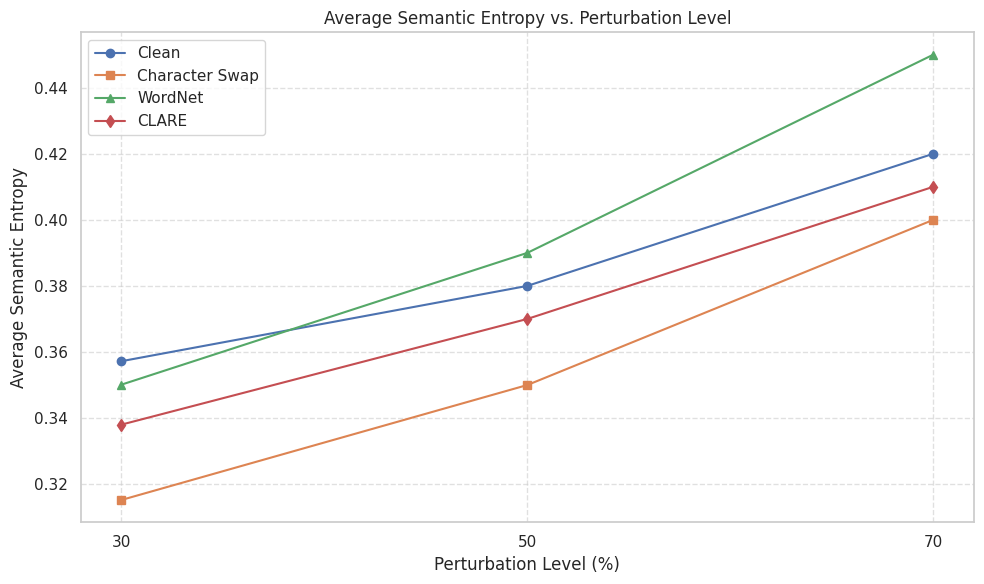

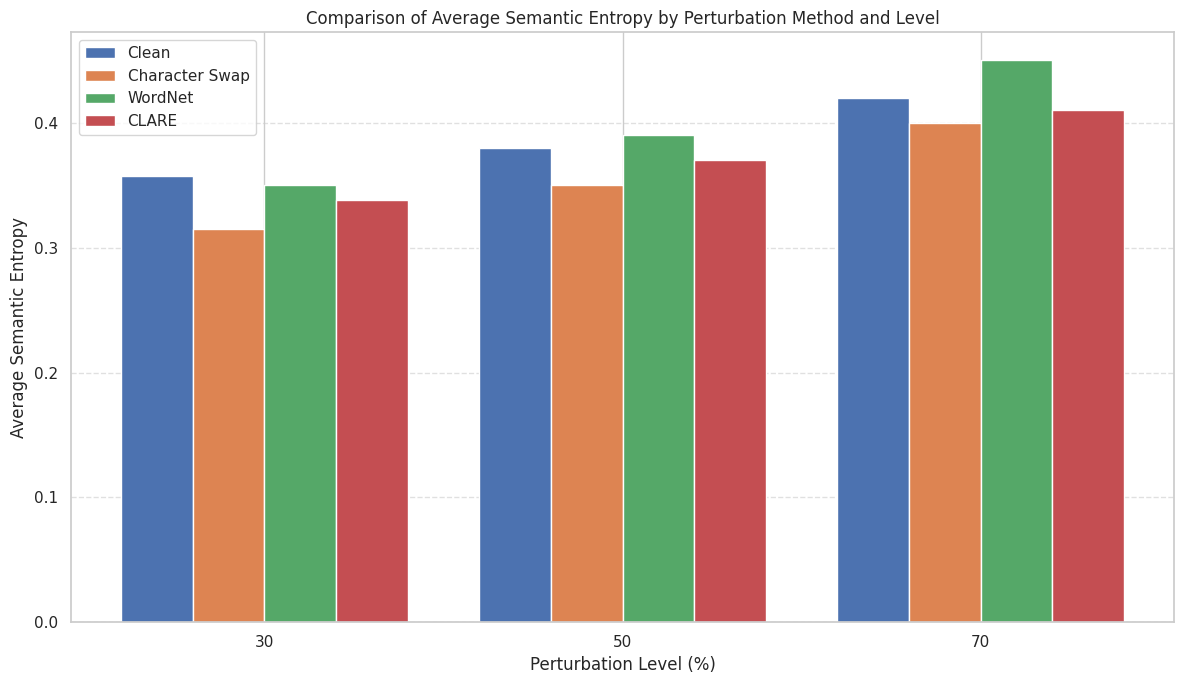

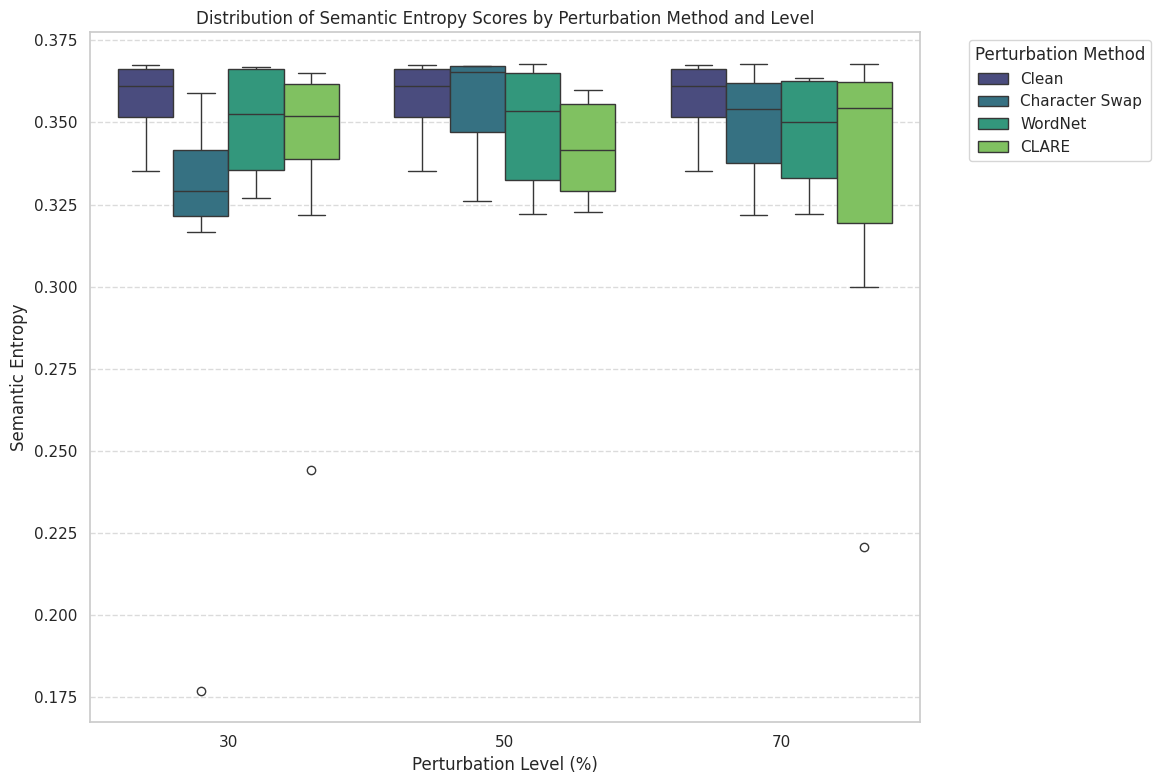

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # Optional, for potentially nicer looking plots

# --- Sample Data (Replace with your actual all_results) ---
# Example structure, fill with your real data

# Convert results to a Pandas DataFrame for easier plotting
df = pd.DataFrame(all_results)
df['perturbation_level'] = (df['perturbation_level'] * 100).astype(int) # Convert to percentage integer

# Rename columns for clarity in plots
df.rename(columns={
    'avg_clean_se': 'Clean',
    'avg_char_swap_se': 'Character Swap',
    'avg_wordnet_se': 'WordNet',
    'avg_clare_se': 'CLARE'
}, inplace=True)

# --- Visualization 1: Line Chart ---
plt.figure(figsize=(10, 6))
plt.plot(df['perturbation_level'], df['Clean'], marker='o', label='Clean')
plt.plot(df['perturbation_level'], df['Character Swap'], marker='s', label='Character Swap')
plt.plot(df['perturbation_level'], df['WordNet'], marker='^', label='WordNet')
plt.plot(df['perturbation_level'], df['CLARE'], marker='d', label='CLARE')

plt.xlabel('Perturbation Level (%)')
plt.ylabel('Average Semantic Entropy')
plt.title('Average Semantic Entropy vs. Perturbation Level')
plt.xticks(df['perturbation_level']) # Ensure ticks are at the exact levels
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Visualization 2: Grouped Bar Chart ---
# We need to 'melt' the DataFrame for easy grouped bar plotting with matplotlib or seaborn
df_melted = df.melt(id_vars='perturbation_level',
                    value_vars=['Clean', 'Character Swap', 'WordNet', 'CLARE'],
                    var_name='Perturbation Method',
                    value_name='Average Semantic Entropy')

plt.figure(figsize=(12, 7))
bar_width = 0.2
x = np.arange(len(df['perturbation_level'])) # the label locations

rects1 = plt.bar(x - 1.5*bar_width, df['Clean'], bar_width, label='Clean')
rects2 = plt.bar(x - 0.5*bar_width, df['Character Swap'], bar_width, label='Character Swap')
rects3 = plt.bar(x + 0.5*bar_width, df['WordNet'], bar_width, label='WordNet')
rects4 = plt.bar(x + 1.5*bar_width, df['CLARE'], bar_width, label='CLARE')

plt.xlabel('Perturbation Level (%)')
plt.ylabel('Average Semantic Entropy')
plt.title('Comparison of Average Semantic Entropy by Perturbation Method and Level')
plt.xticks(x, df['perturbation_level'])
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# --- Visualization 3: Box Plot (Individual Scores) ---
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_individual, x='Perturbation Level (%)', y='Semantic Entropy', hue='Perturbation Method', palette='viridis') # Use the long-format DataFrame
plt.title('Distribution of Semantic Entropy Scores by Perturbation Method and Level')
plt.xlabel('Perturbation Level (%)')
plt.ylabel('Semantic Entropy')
plt.legend(title='Perturbation Method', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()